# ODE Modeling in Python
In the previous notebook, we discussed how to find the best parameters given a function, initial parameter guesses, and data. In this notebook, we will learn how to solve ordinary differential equations (ODE) models and even find numerical solutions to fit the model to existing data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from lmfit import Model

## A Simple ODE
Suppose that we know the concentration of a substance A follows the following differential equation:

$$\frac{dC_{A}}{dt} = -kC_{A}$$

Moreover, we have the data for the concentration of A at various timepoints t. Notice that we can easily solve this ODE analytically to come up with a function $C_A(k, t)$. However, we will solve this numerically to provide us with an intuition on how to solve ODEs and fitting them using data.

Source:
[Kitchin Research Group](https://kitchingroup.cheme.cmu.edu/blog/2013/02/18/Fitting-a-numerical-ODE-solution-to-data/)

### Data

In [2]:
t = [0, 0.1, 0.2, 0.4, 0.8, 1]
Ca_data = [2.0081,  1.5512,  1.1903,  0.7160,  0.2562,  0.1495]

### Visualize the Data

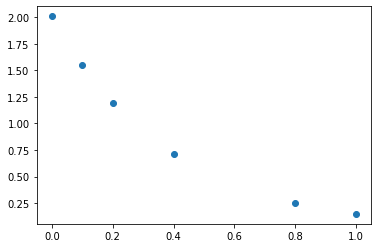

In [3]:
plt.scatter(t, Ca_data)

### Define the Function

In [4]:
def concentration_func(t, k):
    "Function that returns Ca computed from our ODE for an instance of k"
    # define the ODE
    def ode_func(Ca, t):
        return -k * Ca
    
    # set initial value(s)
    Ca_init = Ca_data[0]
    
    # find numerical solution to ode
    Ca_soln = odeint(ode_func, Ca_init, t)
    
    return Ca_soln[:,0]

### Set Initial Parameter Value(s)

In [5]:
k_init = 1

### Plot Initial Curve

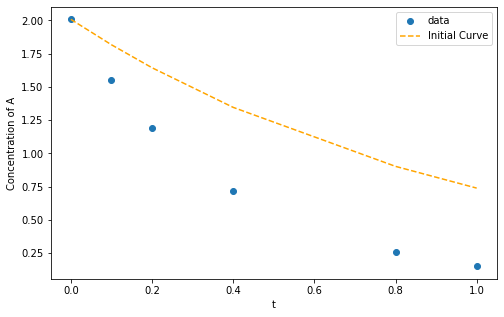

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))

# initial curve
curve_init = concentration_func(t, k_init)

ax.scatter(t, Ca_data, label='data')
ax.plot(t, curve_init, label='Initial Curve', linestyle='--', color='orange')
ax.set_xlabel('t')
ax.set_ylabel('Concentration of A')
ax.legend();

### Determine Best Fit Curve

In [7]:
model = Model(concentration_func)
result = model.fit(Ca_data, t=t, k=k_init)

In [8]:
# display report
result

### Get Best Parameters

In [9]:
k_fit = result.values['k']

### Plot Best Fit Model

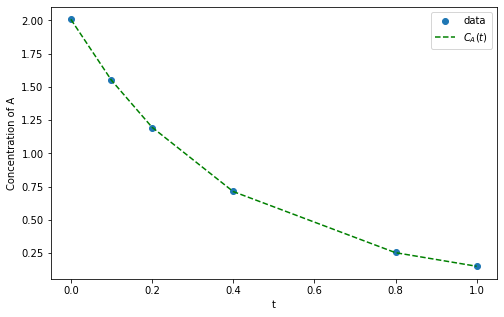

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))

# best curve
curve_fit = concentration_func(t, k_fit)

ax.scatter(t, Ca_data, label='data')
ax.plot(t, curve_fit, label=f'$C_A(t)$', linestyle='--', color='green')
ax.set_xlabel('t')
ax.set_ylabel('Concentration of A')
ax.legend();

### Model Confidence Interval

In [11]:
err = result.eval_uncertainty(sigma=2)

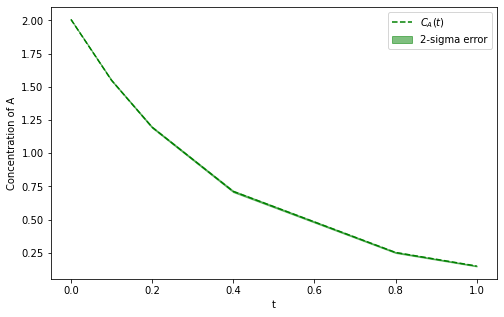

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))

# best curve
curve_fit = concentration_func(t, k_fit)

ax.plot(t, curve_fit, label=f'$C_A(t)$', linestyle='--', color='green')
ax.fill_between(t, curve_fit+err, curve_fit-err, label='2-sigma error',
                color='green', alpha=.5)
ax.set_xlabel('t')
ax.set_ylabel('Concentration of A')
ax.legend();

### Prediction Interval

In [13]:
noise = np.std(Ca_data - curve_fit)
noise

0.00317627204615951

In [14]:
# best curve
curve_fit = concentration_func(t, k_fit)

In [15]:
# determine prediction interval via parametrized bootstrapping
# we assume that the noise comes from a gaussian distribution
preds = np.array([np.random.normal(curve_fit, noise) for j in range(1000)])
upper, lower = np.quantile(preds, [.025, .975], axis=0)

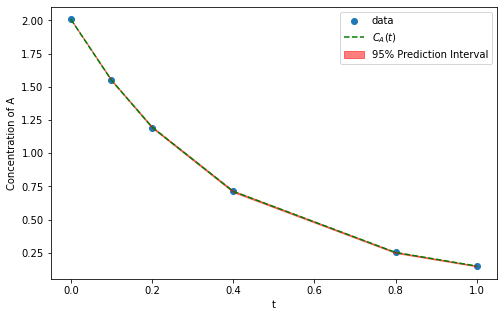

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(t, Ca_data, label='data')
ax.plot(t, curve_fit, label=f'$C_A(t)$', linestyle='--', color='green')
ax.fill_between(t, curve_fit+err, curve_fit-err, label='95% Prediction Interval',
                color='red', alpha=.5)
ax.set_xlabel('t')
ax.set_ylabel('Concentration of A')
ax.legend();

## Population Modeling
The following content is taken from the book "A First Course in Mathematical Modeling" by Frank R. Giordano, William P. Fox, and Steven B. Horton. [Link to Amazon](https://www.amazon.com/First-Course-Mathematical-Modeling/dp/1285050908).

### Malthusian Model (Exercise)
In the late eighteenth century, [Thomas Malthus (1766–1834)](https://www.britannica.com/biography/Thomas-Malthus) anonymously published *An Essay on the Principle of Population as It Affects the Future Improvement of Society*. In the book, Malthus put forward an exponential model of population and concluded that eventually, the population will exceed the capacity to support it.

We begin by looking at the differential equation model:

$$\frac{dP}{dt} = bP - dP = (b - d)P = kP,$$
Where $k = b - d$ is the net of birth rate and death rate (aka Population growth rate).

#### Data
For this exercise, we will use the US Census Data From 1610 to 2020 as reported in [wikipedia](https://en.wikipedia.org/wiki/Demographic_history_of_the_United_States).

In [17]:
df_pop = pd.read_csv('../data/US_population.csv')

In [18]:
df_pop.head()

,Census_Year,Population
0,1610,350
1,1620,2302
2,1630,4646
3,1640,26634
4,1650,50368


<AxesSubplot:xlabel='Census_Year', ylabel='Population'>

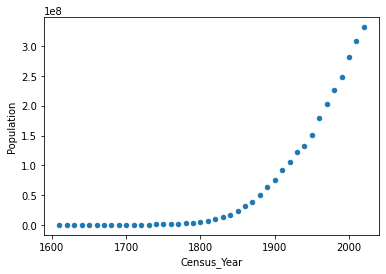

In [19]:
df_pop.plot.scatter(x='Census_Year', y='Population')

#### Instructions
Given the data above, fit the Malthusian Model of Population and discuss the results afterwards.

### Limited Growth Model

While some populations grow exponentially, in most cases, as the population increases, individuals begin to compete with each other for resources such as food and living space. Now, we will refine the Malthusian model to reflect this insight.

Suppose that $k$ from the previous model is no longer constant but a function of the population. Suppose that $k = r(M - P)$. Where $M$ is the maximum population and $r$ is a scaling factor. Then, our updated model will now become:

$$\frac{dP}{dt} = kP = r(M - P)P$$

Which is also known as a Logistic Growth Model

#### Growth of Yeast in Culture

In [20]:
t = np.arange(19)
yeast_biomass = [9.6, 18.3, 29.0, 47.2, 71.1, 119.1, 174.6, 257.3, 350.7, 
                 441.0, 513.3, 559.7, 594.8, 629.4, 640.8, 651.1, 655.9,
                 659.6, 661.8]

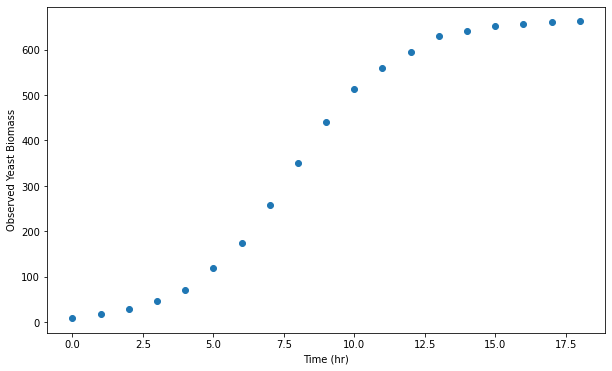

In [21]:
# visualize data
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(t, yeast_biomass, label='data')
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Observed Yeast Biomass');

In [22]:
# define the curve
def yeast_biomass_func(t, r, M):
    def ode_func(P, t):
        return r*(M - P)*P
    
    # set initial values
    P_init = yeast_biomass[0]
    
    # solve ode
    P_soln = odeint(ode_func, P_init, t)
    
    return P_soln[:, 0]

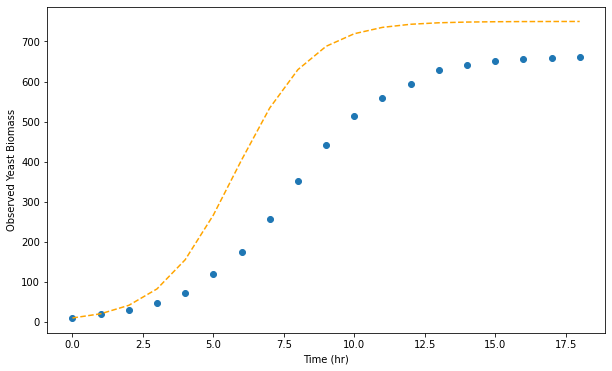

In [23]:
# plot curve with initial parameter guess
r_init = .001
M_init = 750

# compute initial curve
P_guess = yeast_biomass_func(t, r_init, M_init)

# visualize data
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(t, yeast_biomass, label='data')
ax.plot(t, P_guess, label='Initial guess', linestyle='--', color='orange')
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Observed Yeast Biomass');

In [24]:
# Determine Best Fit Parameters and Model
model = Model(yeast_biomass_func)
result = model.fit(yeast_biomass, t=t, r=r_init, M=M_init)

In [25]:
result

In [26]:
# Get Best Parameters
r_fit = result.values['r']
M_fit = result.values['M']

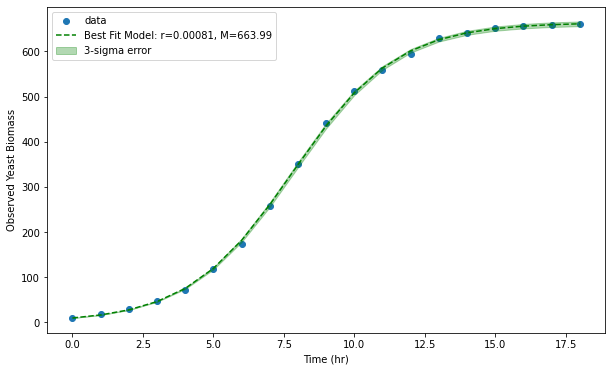

In [27]:
# Plot Best Model with Confidence Interval

# compute initial curve
P_fit = yeast_biomass_func(t, r_fit, M_fit)

# Determine 2-sigma error
err = result.eval_uncertainty(sigma=3)

# visualize data
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(t, yeast_biomass, label='data')
ax.plot(t, P_fit, label=f'Best Fit Model: r={r_fit:.5f}, M={M_fit:.2f}',
        linestyle='--', color='green')

ax.fill_between(t, P_fit + err, P_fit - err, label='3-sigma error',
                color='green', alpha=.3)

ax.set_xlabel('Time (hr)')
ax.set_ylabel('Observed Yeast Biomass')
ax.legend();


## Lotka-Volterra Model
The [Lotka-Volterra Equations (Wikipedia)](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) or the Predator-Prey Model was proposed in the 1920 and is commonly used to describe the population dynamics of two interacting species. In this example, we will discuss the population dynamics of the Canada Lynx (*Lynx canadensis*) and snowshoe hare (*Lepus americanus*).

We will setup the Lotka-Volterra Model for the Hare-Lynx Dynamics as follows:

$$dH = \alpha H - \beta HL$$
$$dL = -\gamma L + \delta HL$$

Where:  
$H$ - is the Hare population  
$L$ - is the Lynx population  

$\alpha, \beta, \gamma, \delta$ are constant parameters defining the population dynamics:  

$\alpha$ - is the natural growth rate of hares when there are no lynx  
$\beta$ - is the natural dying rate of hares due to predation  
$\gamma$ - is the natural dying rate of lynx, when there are no hares.   
$\delta$ - is the factor that describes birth of new lynx due to caught hares

For another example, you can also watch [this youtube video](https://www.youtube.com/watch?v=0jgGbCM7dXk) on fitting Predator-Prey Model to Data.

### Define the Function

In [28]:
def lotka_volterra(t, alpha, beta, gamma, delta):
    def ode(populations, t):
        H = populations[0]
        L = populations[1]
        
        dH = alpha*H - beta*H*L
        dL = -gamma*L + beta*delta*H*L
        
        return [dH, dL]
    
   # set initial value(s)
    pop_init = [5, 20]
    
    # find numerical solution to ode
    populations_soln = odeint(ode, pop_init, t)
    
    return populations_soln

### Set Initial Parameter Values

In [29]:
t = np.arange(100)
alpha_init = 2
beta_init = .3
gamma_init = .5
delta_init = .3

### Play With An Interactive Plot

In [30]:
from ipywidgets import interact, FloatSlider, IntSlider

In [31]:
def plot_interactive_curves(alpha, beta, gamma, delta):
    populations_guess = lotka_volterra(t, alpha, beta,
                                       gamma, delta).T

    H_init = populations_guess[0]
    L_init = populations_guess[1]

    fig, ax = plt.subplots(figsize=(10, 7))
    
    ax.plot(t, H_init, label='Hare', color='green')
    ax.plot(t, L_init, label='Lynx', color='red')
    ax.set_ylim(0,1000)
    ax.legend();

alpha_slider = FloatSlider(value=5, min=0, max=10, step=.1, description='alpha')
beta_slider = FloatSlider(value=.07, min=0, max=.5, step=.1, description='beta')
gamma_slider = FloatSlider(value=.5, min=0, max=1, step=.01, description='gamma')
delta_slider = FloatSlider(value=.1, min=0, max=.5, step=.01, description='delta')

interact(plot_interactive_curves, alpha=alpha_slider, beta=beta_slider,
         gamma=gamma_slider, delta=delta_slider);

interactive(children=(FloatSlider(value=5.0, description='alpha', max=10.0), FloatSlider(value=0.07, descripti…

## SIERD Models and Covid-19 Simulations

Now that we've become much more familiar with ODE modeling in Python as well as built an interactive widget, we can now attempt to model transmission of infectious diseases via ODEs.

### SEIR/D Models
SEIRD model is a type of compartmental models that divides a population into multiple compartments: **S**usceptible, **E**xposed, **I**nfected, **R**ecovered/**D**ead. 

The advantage of these types of models is that we can create them even when data is limited as long as the ODEs are reasonably designed.

We define the SEIRD model as the following:

$\frac{dS}{dt} = -\frac{\beta SI}{N},$

$\frac{dE}{dt} = \frac{\beta SI}{N} - \sigma E,$

$\frac{dI}{dt} = \sigma E - \gamma  I - \mu I,$

$\frac{dR}{dt} = \gamma  I,$

$\frac{dD}{dt} = \mu  I,$

$N = S + E + I + R$

Where,  
$\beta$ is the infection rate  
$\sigma$ is the incubation rate  
$\gamma$ is the recovery rate  
$\mu$ is the mortality rate due to the disease

In [32]:
# df_cases = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')

# df_ph = (df_cases[df_cases.Country=='Philippines']
#          .loc[:, ['Date_reported', 'New_cases', 'New_deaths']])
# df_ph.Date_reported = pd.to_datetime(df_ph.Date_reported)
# df_ph.set_index('Date_reported', inplace=True)

In [33]:
# df_ph.New_cases.rolling(7).sum().plot(figsize=(10, 6))

#### Define the Function

In [34]:
def seird(t, initial_conditions, beta, sigma, gamma, mu):
    
    def ode(initial_conditions, t):
        S, E, I, R, D = initial_conditions
        N = S + E + I + R + D
        
        # define the ODEs
        dS = -beta*S*I/N
        dE = beta*S*I/N - sigma*E
        dI = sigma*E - gamma*I - mu*I
        dR = gamma*I
        dD = mu*I
        
        return [dS, dE, dI, dR, dD]
    
    # find numerical solution to ode
    soln = odeint(ode, initial_conditions, t)
    
    return soln

#### Set Initial Conditions and Parameters

Suppose we based values of the compartmental model on numbers in the Philippines

In [35]:
# set initial value(s)
N_init = 109600000 # Total Population in PH

E_init = 1000 # assumed value
I_init = 50 # assumed value
R_init = 0
D_init = 0

S_init = N_init - E_init - I_init - R_init - D_init
initial_conditions = [S_init, E_init, I_init, R_init, D_init]

In [36]:
# Initial Parameters
sigma_init = 1 / 5.2 # average incubation period is 5.2 days
gamma_init = 1 / 18 # average illness duration is 18 days

# We model transmission/infection rate as the product of Reproduction number and recovery rate
Rt = 3 # for this demonstration, we assume a fixed reproduction rate
beta_init = Rt * gamma_init

mu_init = 60182/3684500 # number of deaths over number of cases

#### Interactive Plot

In [37]:
def plot_interactive_seird(tsteps, E, I, R, D, Rt, sigma, gamma, mu):
    t = np.arange(tsteps)
    
    initial_conditions = [N_init - E - I - R - D, E, I, R, D]
    beta = Rt*gamma
    soln = seird(t, initial_conditions, beta, sigma, gamma, mu)

    S = soln[:, 0]
    E = soln[:, 1]
    I = soln[:, 2]
    R = soln[:, 3]
    D = soln[:, 4]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    labels = ['Susceptible', 'Exposed', 'Infected', 'Recovered', 'Dead']
    colors= ['blue', 'orange', 'red', 'green', 'k']
    for i in range(5):
        ax.plot(t, soln[:, i], label=labels[i], color=colors[i])
    ax.set_xlabel('days')
    ax.set_ylabel('Number of Individuals')
    ax.legend();

In [38]:
# slider for time
t_slider = IntSlider(value=365, min=0, max=1000, description='timesteps')

# sliders for initial conditions
E_slider = IntSlider(value=E_init, min=0, max=1000000, step=1000, description='Exposed')
I_slider = IntSlider(value=I_init, min=0, max=N_init, step=100, description='Infected')
R_slider = IntSlider(value=R_init, min=0, max=N_init, step=100, description='Recovered')
D_slider = IntSlider(value=D_init, min=0, max=N_init, step=100, description='Infected')

# sliders for parameters
Rt_slider = FloatSlider(value=Rt, min=0, max=10, step=.1, description='Rt')
# beta_slider = FloatSlider(value=beta_init, min=0, max=1, step=.02, description='beta')
sigma_slider = FloatSlider(value=sigma_init, min=0, max=.5, step=.02, description='sigma')
gamma_slider = FloatSlider(value=gamma_init, min=0, max=1, step=.02, description='gamma')
mu_slider = FloatSlider(value=mu_init, min=0, max=.5, step=.02, description='mu')

interact(plot_interactive_seird, tsteps=t_slider, E=E_slider, I=I_slider, R=R_slider,
         D=D_slider, Rt=Rt_slider, sigma=sigma_slider, gamma=gamma_slider, mu=mu_slider);

interactive(children=(IntSlider(value=365, description='timesteps', max=1000), IntSlider(value=1000, descripti…

#### Additional Resources
1. [Fitting an SEIRD Model on Covid-19 Data in India](https://towardsdatascience.com/estimating-parameters-of-compartmental-models-from-observed-data-62f87966bb2b)